# EhV

In [1]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [2]:
from pandas.api.types import CategoricalDtype
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import scale, robust_scale
import numpy
from multiprocessing import Pool

## Data import

In [3]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [4]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])
df = df[numpy.load(data_dir / "columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "index.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(102612, 914)

In [ ]:
df.loc["Inf"].reset_index().to_feather(data_dir / f"cells.feather", compression="uncompressed")

In [5]:
selected = df.filter(regex="feat").columns

## Feature correlation

In [6]:
df = df.drop(columns=df.filter(regex='euler').columns)

In [7]:
df = df.loc["Inf"]

In [41]:
%%time
correlation = df.filter(regex="feat.*").corr()

CPU times: user 38.5 s, sys: 35.2 ms, total: 38.5 s
Wall time: 38.7 s


In [42]:
correlation.isna().sum().sum()

0

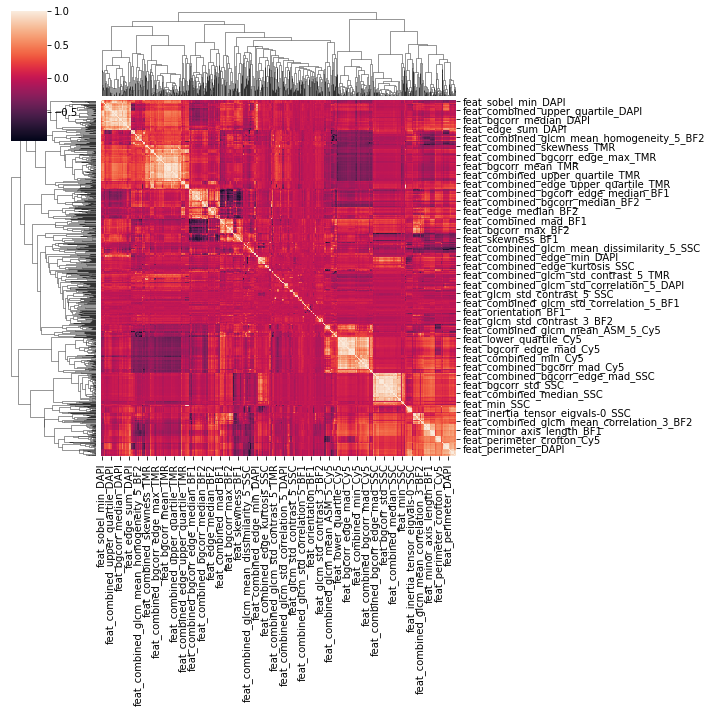

In [43]:
seaborn.clustermap(correlation)

### Pairwise correlated feature removal

In [38]:
def get_correlated_features(df, var, cutoff):
    correlated_features = set()
    correlation = df.corr().abs()
    
    while(numpy.tril(correlation.values, -1).max() > cutoff):
        i,j = numpy.unravel_index(numpy.tril(correlation.values, -1).argmax(), correlation.shape)
        
        if var[correlation.columns[i]] >= var[correlation.columns[j]]:
            colname = correlation.columns[j]
        else:
            colname = correlation.columns[i]
        correlated_features.add(colname)
        
        correlation = df.drop(columns=correlated_features).corr().abs()
                
    return correlated_features

In [39]:
var = df.filter(regex="feat").var()

In [ ]:
%%time
def func(df, var, c):
    correlated_features = get_correlated_features(
        df, var,
        cutoff=c
    )
    corr2 = df.drop(columns=correlated_features).corr()
    corr2 = numpy.abs(corr2.values)
    corr2[numpy.triu_indices(corr2.shape[0], -1)] = numpy.nan
    return numpy.nanmean(corr2), correlated_features

cutoffs = numpy.arange(0.2, 1.001, step=0.01)
res = []
tmp_df = df.filter(regex="feat")
for c in cutoffs[::-1]:
    print(c)
    m, cf = func(tmp_df, var, c)
    tmp_df = tmp_df.drop(columns=cf)

    res.append((c, m, len(cf)))

1.0000000000000007
0.9900000000000007


In [47]:
res = pandas.DataFrame(data=res, columns=["cutoff", "corr", "len"]).set_index("cutoff")

In [48]:
res = res.dropna()

In [21]:
res = res.iloc[1:]

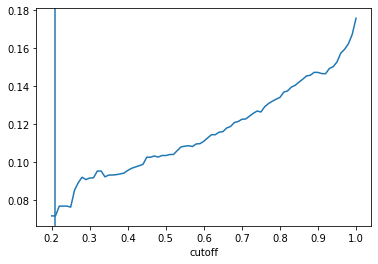

In [49]:
ax = res["corr"].plot()
ax.axvline(res["corr"].idxmin())

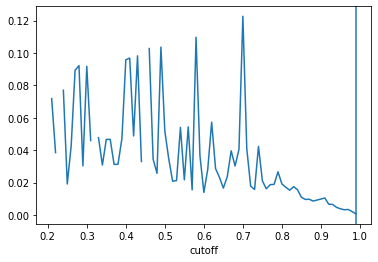

In [50]:
ax = (res["corr"] / res["len"]).plot()
ax.axvline((res["corr"] / res["len"]).idxmin())

In [24]:
c = res["corr"].idxmin()
correlated_features = get_correlated_features(
    corr, var,
    cutoff=c
)

In [25]:
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

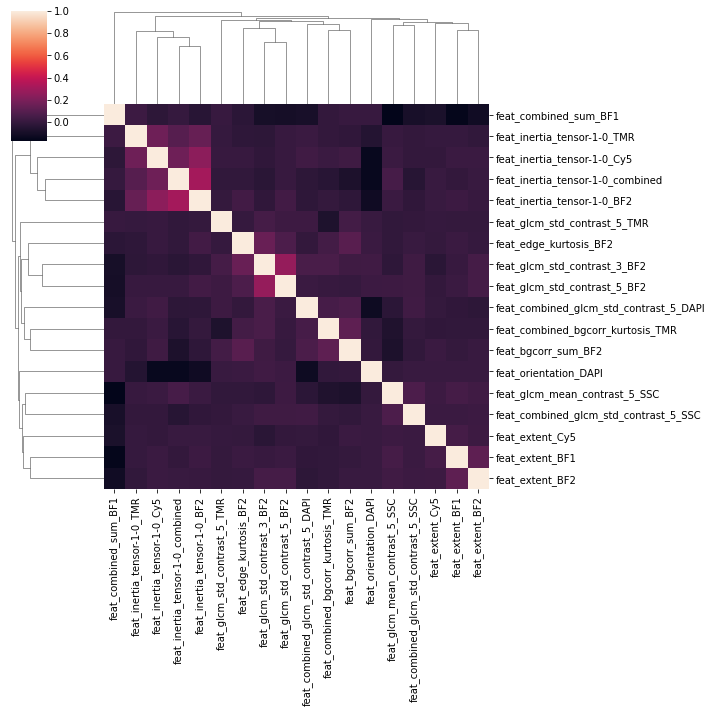

In [26]:
seaborn.clustermap(correlation2)

In [27]:
tmp = correlation2.values.copy()
tmp[numpy.triu_indices(correlation2.shape[0], -1)] = numpy.nan
numpy.nanmean(tmp)

0.0011097585043160477

In [29]:
with open(str(data_dir / f"results/scip/202202071958/pairwise_uncorrelated_cols.txt"), "w") as fh:
    for col in df.filter(regex="feat").drop(correlated_features):
        fh.write(f"{col}\n")

KeyError: 'feat_combined_sobel_min_TMR'

In [ ]:
df = df.drop(columns=correlated_features)

In [ ]:
df.shape

In [ ]:
df.filter(regex="feat")

### Clustering features based on correlation

In [44]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cut_tree

In [45]:
z = fastcluster.linkage(correlation, method="ward")

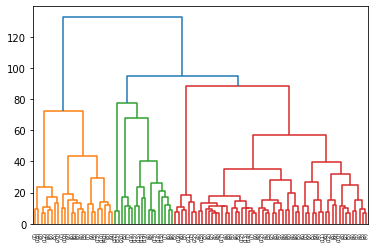

In [46]:
_ = dendrogram(z, truncate_mode="lastp", p=100)

In [68]:
def func(n):
    membership = cut_tree(z, n_clusters=n)[:, 0]
    selected = []
    for i, gdf in df.filter(regex="feat").T.groupby(membership):
        col = correlation[gdf.index].abs().mean(axis=0).idxmin()
        selected.append(col)
    corr2 = df[selected].corr()
    return n, numpy.tril(corr2).mean()

corr_per_feature = []
n_features = numpy.arange(10, df.filter(regex="feat").shape[1], step=10).tolist() + [df.filter(regex="feat").shape[1]]
with Pool(processes=10) as pool:
    res = pool.map_async(func, n_features).get()

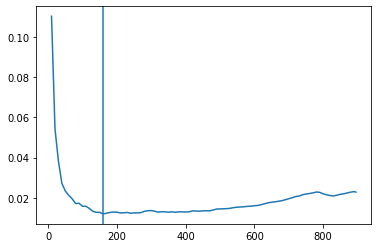

In [136]:
ax = res["corr"].plot()
ax.axvline(res["corr"].idxmin())

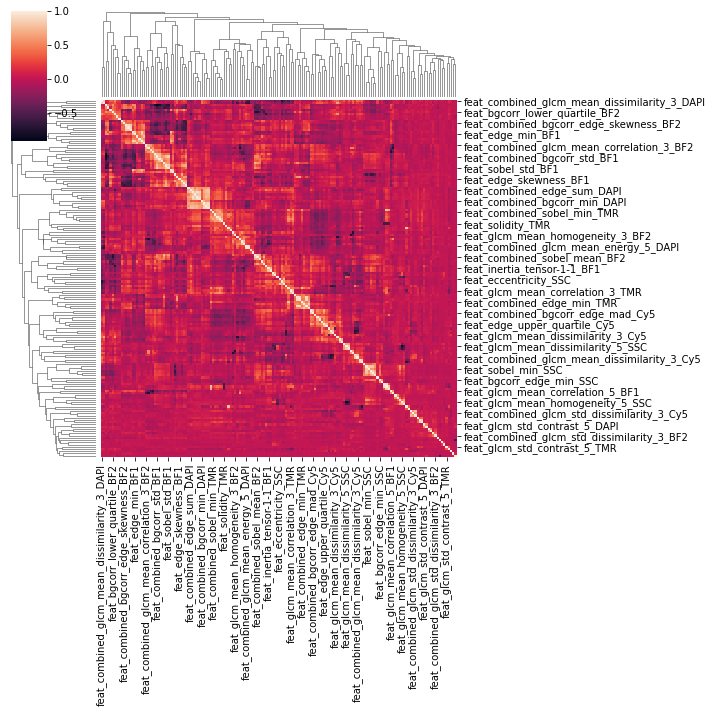

In [91]:
membership = cut_tree(z, n_clusters=res["corr"].idxmin())[:, 0]
selected = []
for i, gdf in df.filter(regex="feat").T.groupby(membership):
    col = correlation[gdf.index].abs().mean(axis=0).idxmin()
    selected.append(col)
corr2 = df[selected].corr()
    
seaborn.clustermap(corr2)

In [121]:
numpy.tril(corr2, -1).max()

0.9429939165538611

In [92]:
with open(str(data_dir / f"results/scip/202202071958/uncorrelated_cols.txt"), "w") as fh:
    for col in selected:
        fh.write(f"{col}\n")

# Dimensionality reduction

In [6]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale, robust_scale
import umap
from sklearn.model_selection import train_test_split

### Control + infected

In [ ]:
pca = PCA().fit_transform(scale(df[selected].fillna(0)))

In [ ]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none")

In [ ]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df["meta_type"], s=1, alpha=0.5, edgecolors="none")

In [ ]:
pca = PCA(n_components=0.95).fit_transform(scale(df[selected].fillna(0)))

In [ ]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection = model.fit_transform(pca)

In [ ]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none", ax=ax)

In [ ]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df["meta_group"], 
    hue_order=df["meta_group"].cat.categories,
    s=1, alpha=0.5, edgecolors="none", ax=ax)

In [ ]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df["meta_type"],
    s=1, alpha=0.5, edgecolors="none", ax=ax)

### Infected only

#### PCA

In [12]:
%%time
pca = PCA(n_components=0.95).fit_transform(scale(df.loc["Inf"][selected].fillna(0)))

CPU times: user 21min 17s, sys: 18.1 s, total: 21min 35s
Wall time: 4min 2s


<AxesSubplot:>

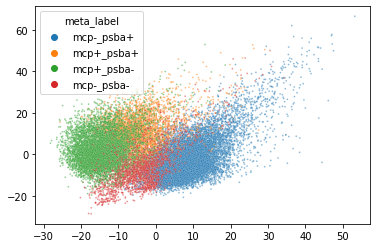

In [13]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df.loc["Inf"]["meta_label"], s=3, alpha=0.5, edgecolors="none")

<AxesSubplot:>

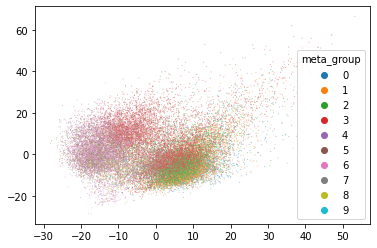

In [15]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df.loc["Inf"].index.get_level_values("meta_group"), s=1, alpha=0.5, edgecolors="none")

In [16]:
from sklearn.manifold import MDS

In [17]:
mds_model = MDS(n_components=2, random_state=0, n_jobs=10)

In [45]:
%%time
mds = mds_model.fit_transform(scale(df.loc["Inf"][selected].fillna(0)))

CPU times: user 1.18 s, sys: 1.76 s, total: 2.94 s
Wall time: 3min 23s


#### T-SNE

In [25]:
%%time
tsne = TSNE(n_components=2, n_jobs=16, random_state=0, init="pca", learning_rate="auto").fit_transform(scale(df.loc["Inf"][selected].fillna(0)))

/data/gent/420/vsc42015/python_lib_skitty/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


CPU times: user 16min 19s, sys: 32.1 s, total: 16min 51s
Wall time: 2min 17s


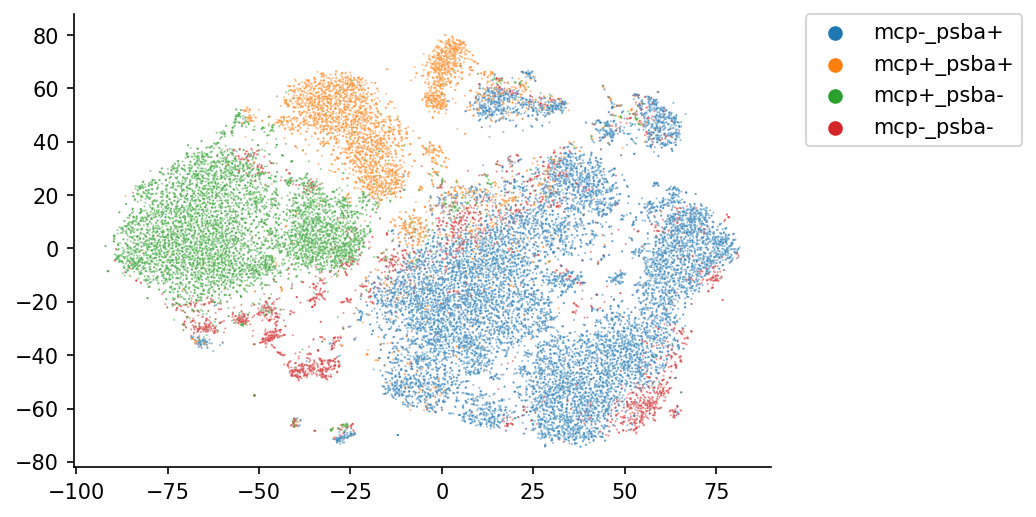

In [26]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.5, edgecolors="none", hue=df.loc["Inf"]["meta_label"], ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)

<AxesSubplot:>

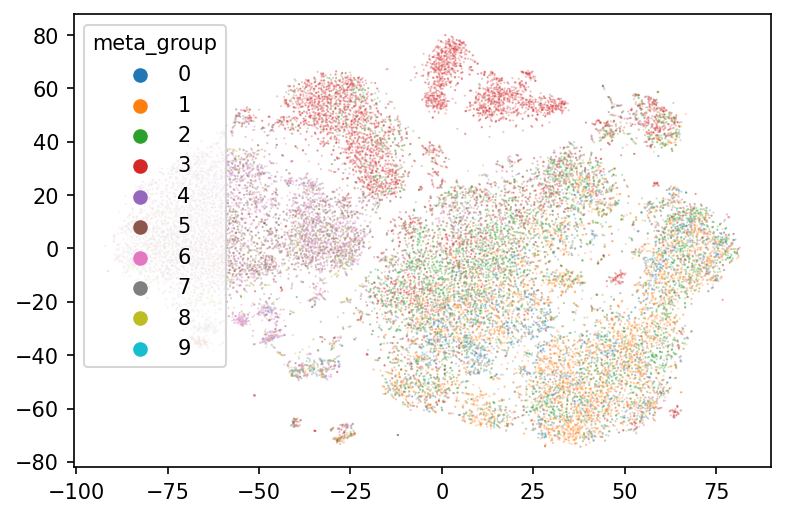

In [28]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.3, edgecolors="none", hue=df.loc["Inf"].index.get_level_values("meta_group"), ax=ax)

**Healthy cells**

<AxesSubplot:xlabel='dim_tsne_1', ylabel='dim_tsne_2'>

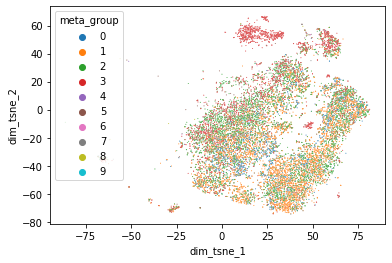

In [50]:
seaborn.scatterplot(data=tmp_df, x="dim_tsne_1", y="dim_tsne_2", hue="meta_group", s=1, edgecolors="none")

In [116]:
tmp_df = df.loc["Inf"][df.loc["Inf"]["meta_label"] == "mcp-_psba+"].copy()
tmp_df["dim_tsne_1"] = tsne[df.loc["Inf"]["meta_label"] == "mcp-_psba+", 0]
tmp_df["dim_tsne_2"] = tsne[df.loc["Inf"]["meta_label"] == "mcp-_psba+", 1]

In [117]:
corr = tmp_df.filter(regex="feat|dim").corr()

In [118]:
corr["dim_tsne_1"].abs().sort_values(ascending=False).iloc[:20]

dim_tsne_1                           1.000000
feat_euler_number_TMR                0.626861
feat_max_TMR                         0.585155
feat_equivalent_diameter_TMR         0.582517
feat_combined_skewness_BF2           0.580102
feat_combined_bgcorr_skewness_BF2    0.580102
feat_minor_axis_length_TMR           0.578435
feat_upper_quartile_TMR              0.576514
feat_mean_TMR                        0.576266
feat_median_TMR                      0.574493
feat_edge_max_TMR                    0.574088
feat_lower_quartile_TMR              0.573503
feat_edge_std_TMR                    0.573103
feat_bgcorr_edge_std_TMR             0.573103
feat_min_TMR                         0.572233
feat_edge_upper_quartile_TMR         0.571546
feat_edge_mean_TMR                   0.570916
feat_edge_median_TMR                 0.570532
feat_edge_lower_quartile_TMR         0.570028
feat_edge_min_TMR                    0.567514
Name: dim_tsne_1, dtype: float64

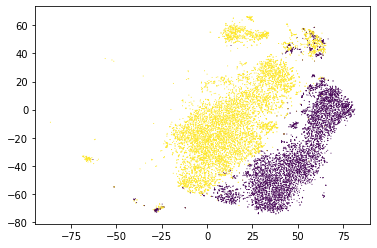

In [119]:
feat = "feat_euler_number_TMR"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

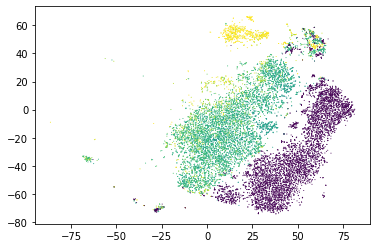

In [120]:
feat = "feat_max_TMR"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

In [121]:
corr["dim_tsne_2"].abs().sort_values(ascending=False).iloc[:20]

dim_tsne_2                               1.000000
feat_combined_edge_max_BF2               0.559646
feat_combined_edge_sum_TMR               0.551407
feat_bgcorr_edge_median_BF1              0.547269
feat_combined_edge_upper_quartile_BF2    0.539106
feat_bgcorr_edge_upper_quartile_BF1      0.536379
feat_bgcorr_edge_mean_BF1                0.535183
feat_combined_sum_TMR                    0.532580
feat_combined_edge_mean_BF2              0.531366
feat_bgcorr_edge_lower_quartile_BF1      0.526301
feat_bgcorr_edge_upper_quartile_BF2      0.521978
feat_bgcorr_sum_BF1                      0.521217
feat_combined_sobel_mean_DAPI            0.512139
feat_bgcorr_edge_median_BF2              0.511932
feat_bgcorr_edge_mean_BF2                0.506623
feat_bgcorr_edge_sum_BF1                 0.505769
feat_bgcorr_mean_BF1                     0.503973
feat_bgcorr_edge_sum_BF2                 0.499898
feat_combined_edge_median_BF2            0.499822
feat_combined_edge_max_DAPI              0.499034


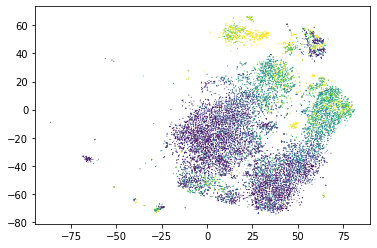

In [123]:
feat = "feat_combined_edge_max_BF2"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

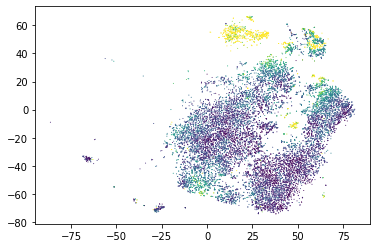

In [124]:
feat = "feat_combined_edge_sum_TMR"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

**Infected, healthy cells**

In [103]:
tmp_df = df.loc["Inf"][df.loc["Inf"]["meta_label"] == "mcp+_psba+"].copy()
tmp_df["dim_tsne_1"] = tsne[df.loc["Inf"]["meta_label"] == "mcp+_psba+", 0]
tmp_df["dim_tsne_2"] = tsne[df.loc["Inf"]["meta_label"] == "mcp+_psba+", 1]

In [104]:
corr = tmp_df.filter(regex="feat|dim").corr()

In [105]:
corr["dim_tsne_1"].abs().sort_values(ascending=False).iloc[:20]

dim_tsne_1                                1.000000
feat_edge_mean_DAPI                       0.516262
feat_edge_upper_quartile_DAPI             0.513018
feat_edge_median_DAPI                     0.511941
feat_lower_quartile_DAPI                  0.508088
feat_combined_edge_upper_quartile_BF2     0.505350
feat_median_DAPI                          0.501757
feat_mean_DAPI                            0.497180
feat_edge_lower_quartile_DAPI             0.496155
feat_combined_edge_mean_BF2               0.493986
feat_combined_mean_DAPI                   0.492540
feat_combined_edge_median_BF2             0.491857
feat_combined_edge_mean_DAPI              0.487945
feat_combined_median_BF2                  0.477481
feat_max_DAPI                             0.477282
feat_combined_max_DAPI                    0.477282
feat_combined_edge_upper_quartile_DAPI    0.475499
feat_bgcorr_mean_DAPI                     0.473566
feat_combined_upper_quartile_BF2          0.471295
feat_upper_quartile_DAPI       

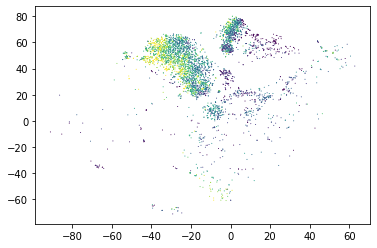

In [106]:
feat = "feat_edge_mean_DAPI"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

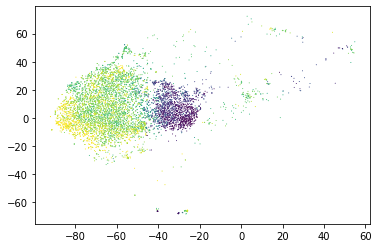

In [43]:
feat = "feat_combined_skewness_BF1"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_tsne_1', ylabel='dim_tsne_2'>

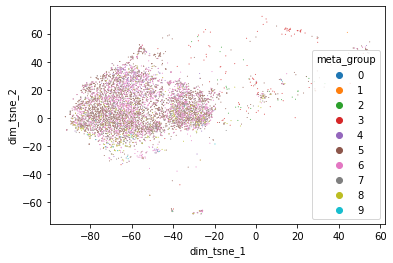

In [44]:
seaborn.scatterplot(data=tmp_df, x="dim_tsne_1", y="dim_tsne_2", hue="meta_group", s=1, edgecolors="none")

**Dead cells**

In [30]:
tmp_df = df.loc["Inf"][df.loc["Inf"]["meta_label"] == "mcp-_psba-"].copy()
tmp_df["dim_tsne_1"] = tsne[df.loc["Inf"]["meta_label"] == "mcp-_psba-", 0]
tmp_df["dim_tsne_2"] = tsne[df.loc["Inf"]["meta_label"] == "mcp-_psba-", 1]

In [31]:
corr = tmp_df.filter(regex="feat|dim").corr()

In [37]:
corr["dim_tsne_1"].abs().sort_values(ascending=False).iloc[:20]

dim_tsne_1                                   1.000000
feat_glcm_mean_contrast_5_DAPI               0.533750
feat_glcm_mean_dissimilarity_5_DAPI          0.523070
feat_std_TMR                                 0.519613
feat_bgcorr_std_TMR                          0.519613
feat_euler_number_TMR                        0.516561
feat_max_TMR                                 0.506235
feat_glcm_mean_energy_5_BF1                  0.503970
feat_glcm_mean_energy_5_BF2                  0.502336
feat_bgcorr_max_TMR                          0.496146
feat_bgcorr_mad_TMR                          0.494845
feat_mad_TMR                                 0.494845
feat_edge_std_TMR                            0.491481
feat_bgcorr_edge_std_TMR                     0.491481
feat_combined_bgcorr_kurtosis_BF1            0.482025
feat_combined_kurtosis_BF1                   0.482025
feat_combined_glcm_mean_homogeneity_5_BF2    0.481605
feat_combined_glcm_mean_energy_5_BF2         0.478999
feat_upper_quartile_TMR     

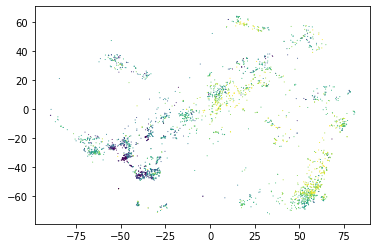

In [34]:
feat = "feat_glcm_mean_contrast_5_DAPI"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

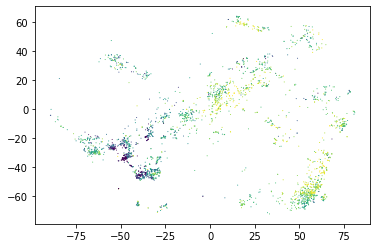

In [35]:
feat = "feat_glcm_mean_dissimilarity_5_DAPI"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

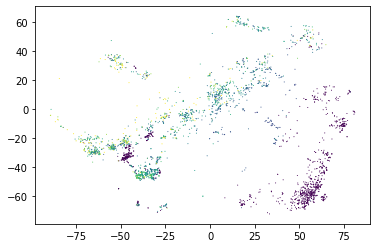

In [36]:
feat = "feat_std_TMR"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

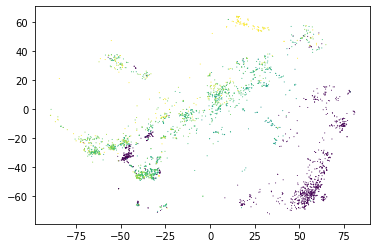

In [38]:
feat = "feat_max_TMR"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

**Infected, inactive cells**

In [39]:
tmp_df = df.loc["Inf"][df.loc["Inf"]["meta_label"] == "mcp+_psba-"].copy()
tmp_df["dim_tsne_1"] = tsne[df.loc["Inf"]["meta_label"] == "mcp+_psba-", 0]
tmp_df["dim_tsne_2"] = tsne[df.loc["Inf"]["meta_label"] == "mcp+_psba-", 1]

In [40]:
corr = tmp_df.filter(regex="feat|dim").corr()

In [41]:
corr["dim_tsne_1"].abs().sort_values(ascending=False).iloc[:20]

dim_tsne_1                                 1.000000
feat_combined_bgcorr_upper_quartile_BF2    0.686390
feat_combined_skewness_BF1                 0.659922
feat_combined_bgcorr_skewness_BF1          0.659922
feat_bgcorr_edge_upper_quartile_BF2        0.654219
feat_skewness_BF1                          0.640763
feat_bgcorr_skewness_BF1                   0.640763
feat_bgcorr_edge_median_BF2                0.639900
feat_bgcorr_edge_mean_BF2                  0.638044
feat_bgcorr_median_BF2                     0.635762
feat_combined_skewness_BF2                 0.631520
feat_combined_bgcorr_skewness_BF2          0.631520
feat_bgcorr_edge_median_BF1                0.627900
feat_bgcorr_edge_sum_BF2                   0.622429
feat_skewness_BF2                          0.620353
feat_bgcorr_skewness_BF2                   0.620353
feat_bgcorr_edge_upper_quartile_BF1        0.620179
feat_bgcorr_mean_BF1                       0.618773
feat_bgcorr_edge_mean_BF1                  0.613305
feat_combine

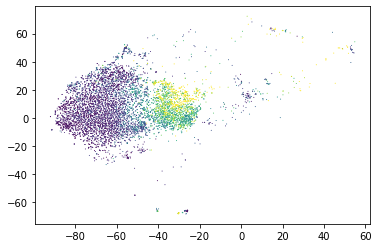

In [42]:
feat = "feat_combined_bgcorr_upper_quartile_BF2"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

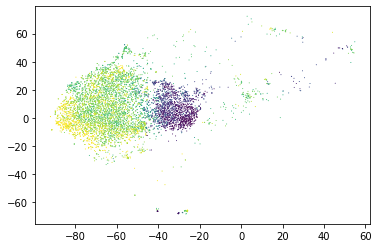

In [43]:
feat = "feat_combined_skewness_BF1"
norm = matplotlib.colors.Normalize(vmin=tmp_df[feat].quantile(0.05), vmax=tmp_df[feat].quantile(0.95))
plt.scatter(tmp_df["dim_tsne_1"], tmp_df["dim_tsne_2"], c=tmp_df[feat], s=1, edgecolors="none", cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_tsne_1', ylabel='dim_tsne_2'>

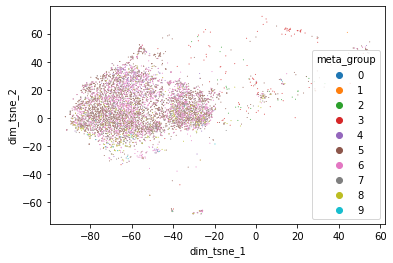

In [44]:
seaborn.scatterplot(data=tmp_df, x="dim_tsne_1", y="dim_tsne_2", hue="meta_group", s=1, edgecolors="none")

# Clustering

In [52]:
with open(str(data_dir / "fluor+morphpca_metaclusters.txt")) as fh:
    clusters = numpy.array(fh.read().split("\n")[:-1], dtype=int)

In [56]:
cat_type = CategoricalDtype(categories=sorted(numpy.unique(clusters)), ordered=True)
df["meta_clusters"] = -1
df.loc["Inf", "meta_clusters"] = clusters
df["meta_clusters"] = df["meta_clusters"].astype(cat_type)

/apps/gent/CO7/skylake-ib/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


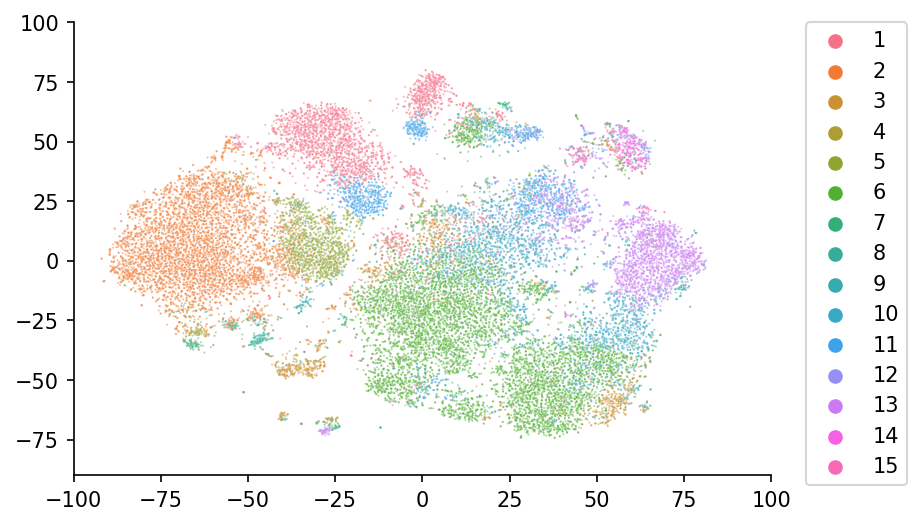

In [57]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.5, edgecolors="none", hue=df.loc["Inf"]["meta_clusters"], ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-90, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)

In [67]:
cluster_abundances = df.loc["Inf"].groupby(["meta_clusters", "meta_label"]).size() / df.loc["Inf"].groupby("meta_clusters").size()

In [89]:
max_abundance = cluster_abundances.groupby("meta_clusters").idxmax()
for r in max_abundance:
    if r[1] == "mcp-_psba-":
        print(r)

(3, 'mcp-_psba-')
(4, 'mcp-_psba-')
(8, 'mcp-_psba-')
(9, 'mcp-_psba-')


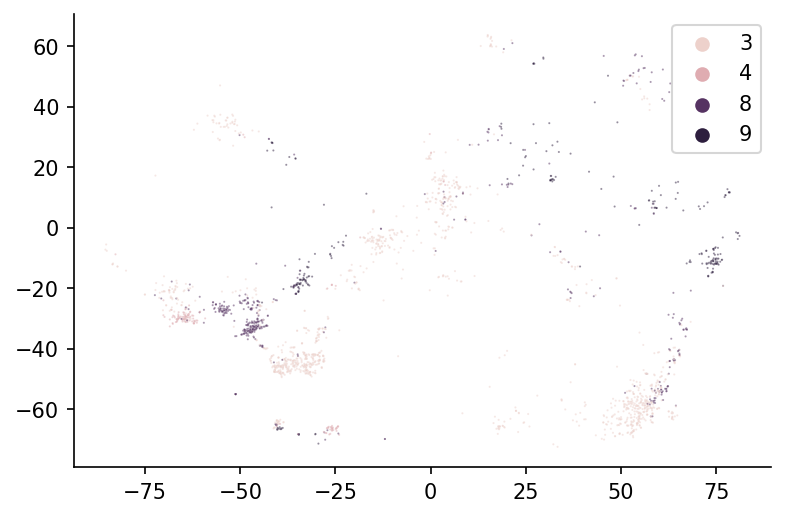

In [99]:
fig, ax = plt.subplots(dpi=150)
sel = df.loc["Inf"]["meta_clusters"].isin([3, 4, 8, 9])
seaborn.scatterplot(x=tsne[sel, 0], y=tsne[sel, 1], s=1, alpha=0.5, hue=df.loc["Inf"]["meta_clusters"][sel].tolist(), edgecolors="none", ax=ax)
seaborn.despine(fig)

In [59]:
with open(str(data_dir / "fluor_metaclusters.txt")) as fh:
    clusters = numpy.array(fh.read().split("\n")[:-1], dtype=int)

In [60]:
cat_type = CategoricalDtype(categories=sorted(numpy.unique(clusters)), ordered=True)
df["meta_fluor_clusters"] = -1
df.loc["Inf", "meta_fluor_clusters"] = clusters
df["meta_fluor_clusters"] = df["meta_fluor_clusters"].astype(cat_type)

/apps/gent/CO7/skylake-ib/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


/tmp/ipykernel_65958/2792013934.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.5, edgecolors="none", hue=df.loc["Inf", "meta_fluor_clusters"])


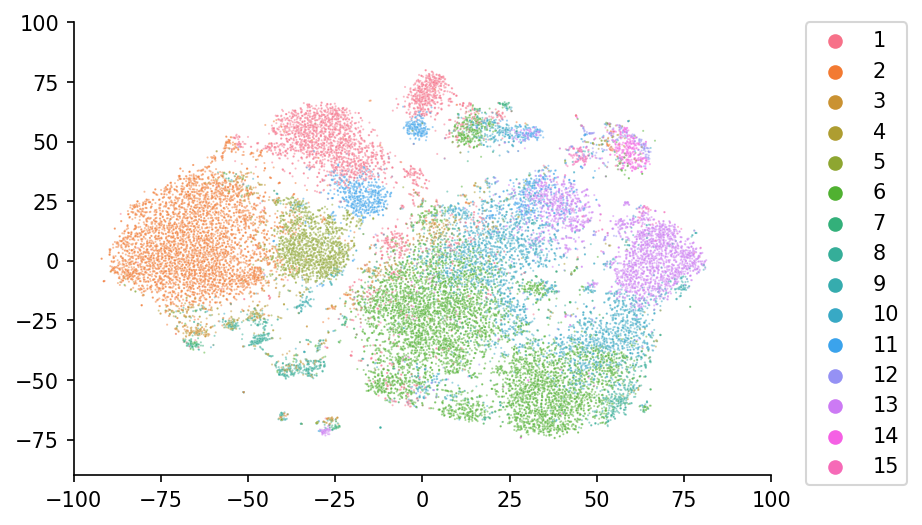

In [61]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.5, edgecolors="none", hue=df.loc["Inf", "meta_fluor_clusters"])
ax.set_xlim(-100, 100)
ax.set_ylim(-90, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)

In [92]:
metrics.adjusted_rand_score(df.loc["Inf"]["meta_clusters"], df.loc["Inf"]["meta_fluor_clusters"])

0.8133630882592933

In [93]:
metrics.adjusted_mutual_info_score(df.loc["Inf"]["meta_clusters"], df.loc["Inf"]["meta_fluor_clusters"])

0.8274372457210468

#### UMAP

In [34]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection_pca = model.fit_transform(pca)

CPU times: user 25.7 s, sys: 737 ms, total: 26.4 s
Wall time: 24 s


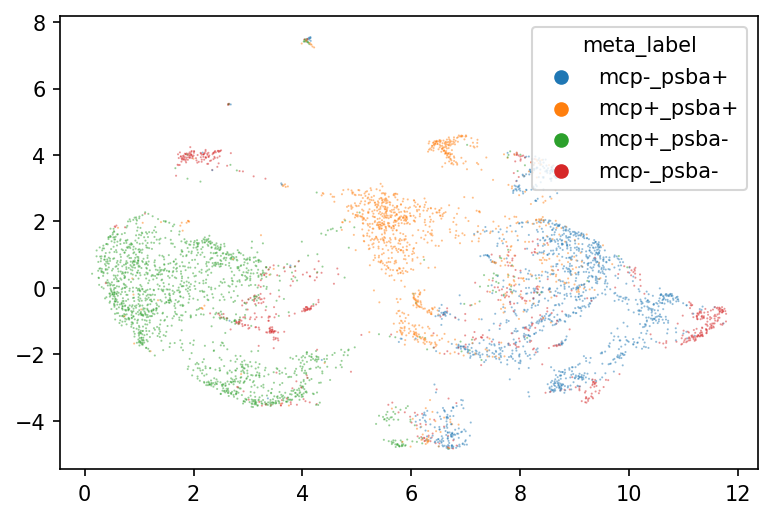

In [36]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection_pca[:, 0], y=projection_pca[:, 1], hue=df2["meta_label"], s=1, alpha=0.5, edgecolors="none", ax=ax)

In [37]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection_kpca = model.fit_transform(k_pca)

CPU times: user 14.9 s, sys: 781 ms, total: 15.6 s
Wall time: 13.3 s


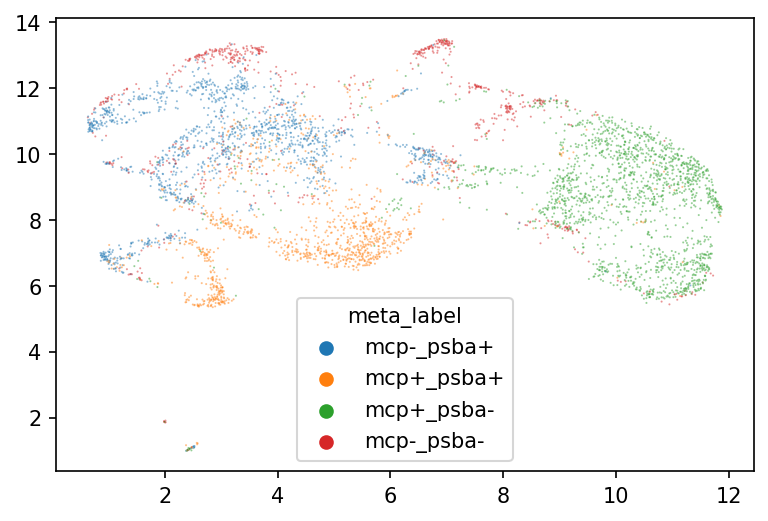

In [38]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection_kpca[:, 0], y=projection_kpca[:, 1], hue=df2["meta_label"], s=1, alpha=0.5, edgecolors="none", ax=ax)

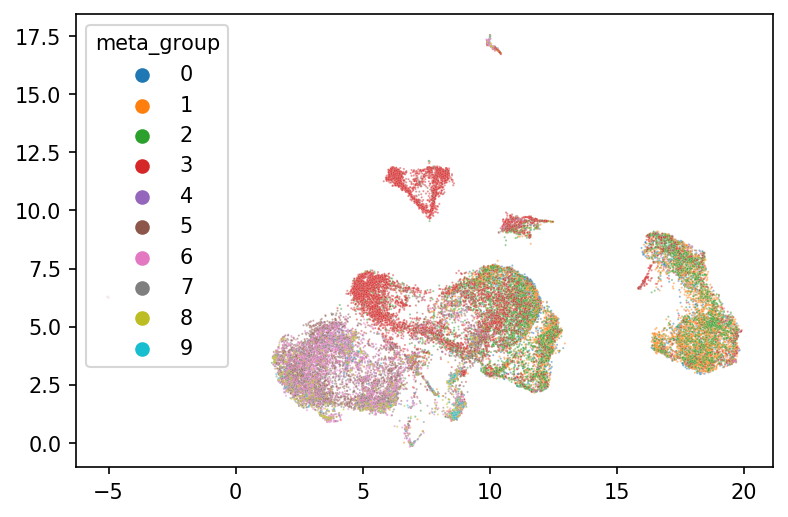

In [35]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df.loc["Inf"].index.get_level_values("meta_group"), 
    hue_order=df.loc["Inf"].index.get_level_values("meta_group").categories,
    s=1, alpha=0.5, edgecolors="none", ax=ax)

In [41]:
gmm = GaussianMixture(n_components=8)

In [42]:
%%time
gmm.fit(pca)

CPU times: user 50.5 s, sys: 1min 9s, total: 2min
Wall time: 16.1 s


GaussianMixture(n_components=8)

In [43]:
df["meta_cluster"] = None
df.loc["Inf", "meta_cluster"] = gmm.predict(pca)
df["meta_cluster"] = df["meta_cluster"].astype("category")

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2914: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


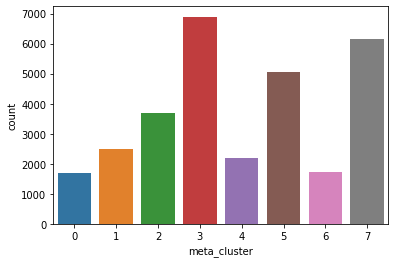

In [44]:
seaborn.countplot(data=df, x="meta_cluster")

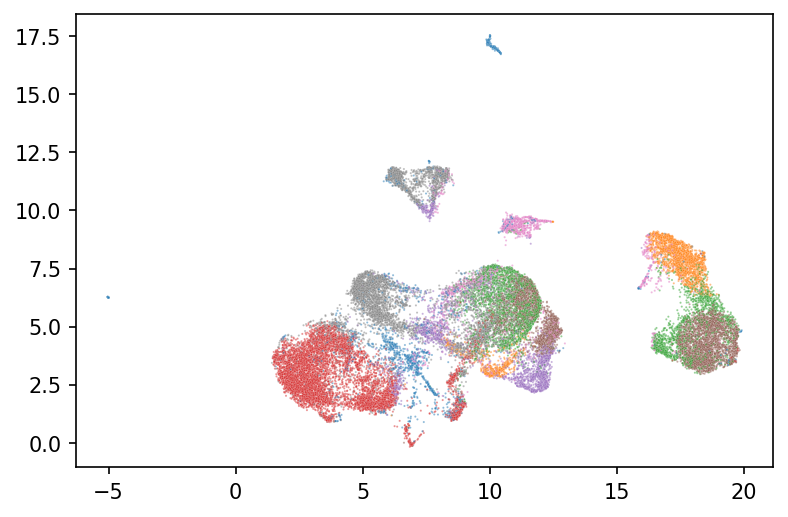

In [46]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df.loc["Inf"]["meta_cluster"], s=1, alpha=0.5, edgecolors="none", ax=ax, legend=False)

In [48]:
from sklearn.neighbors import NearestNeighbors

In [93]:
nbrs = NearestNeighbors(n_neighbors=2, radius=10, n_jobs=10, metric="cosine").fit(pca)

In [94]:
%%time
dist, index = nbrs.kneighbors(pca, n_neighbors=2, return_distance=True)

CPU times: user 21.8 s, sys: 24 s, total: 45.7 s
Wall time: 13.1 s


In [95]:
from kneed import KneeLocator
kneedle = KneeLocator(numpy.arange(dist.shape[0]), sorted(dist[:, -1]), S=1.0, curve="convex", direction="increasing")

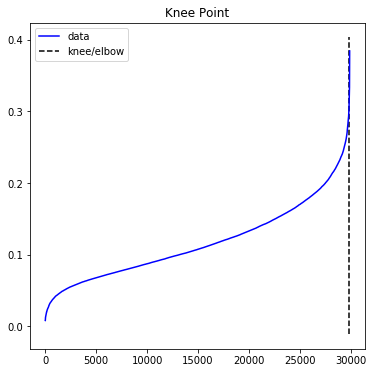

In [96]:
kneedle.plot_knee()

In [97]:
eps = numpy.sort(dist[:, -1])[kneedle.elbow]

In [102]:
dbscan = DBSCAN(eps=0.1, min_samples=5, metric="cosine")

In [103]:
%%time
df["meta_cluster"] = None
df.loc["Inf", "meta_cluster"] = dbscan.fit_predict(pca)
df["meta_cluster"] = df["meta_cluster"].astype("category")

CPU times: user 9.11 s, sys: 14.9 s, total: 24 s
Wall time: 4.44 s


/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


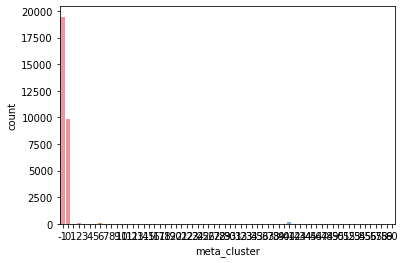

In [104]:
seaborn.countplot(data=df, x="meta_cluster")

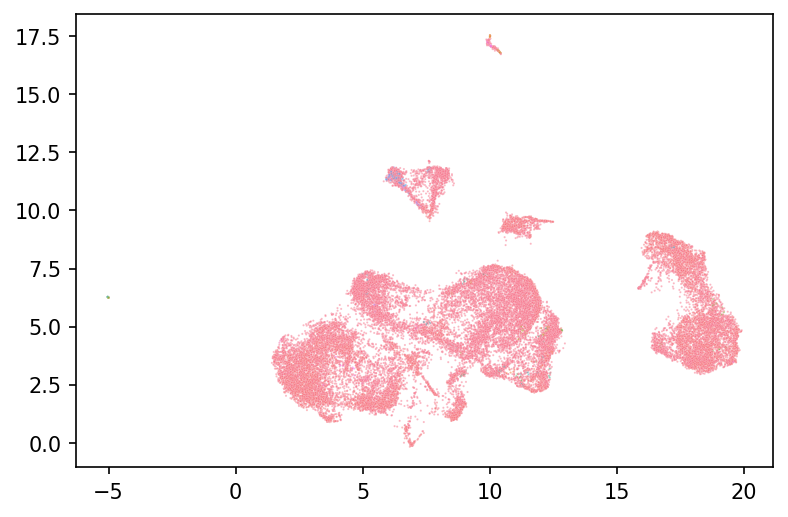

In [105]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df.loc["Inf"]["meta_cluster"], s=1, alpha=0.5, edgecolors="none", ax=ax, legend=False)

In [38]:
slingshot_df = pandas.DataFrame(
    data=numpy.hstack([projection, pca, df.loc["Inf"][["meta_cluster"]]]),
    columns=["umap_0",  "umap_1"] + [f"pca_{i}" for i in range(pca.shape[1])] + ["cluster"]
)

In [39]:
slingshot_df.to_feather(data_dir / f"results/scip/202201311209_skitty/slingshot_pca0.75.feather", compression="uncompressed")

In [28]:
df["meta_slingshot_pt"] = None
df.loc["Inf", "meta_slingshot_pt"] = feather.read_feather('/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201311209_skitty/pt.feather').values.flatten()

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2914: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


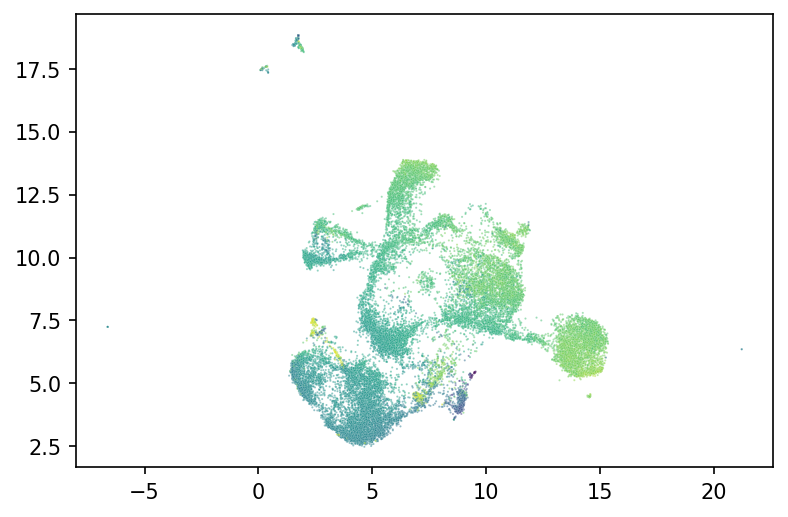

In [29]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    x=projection[:, 0], y=projection[:, 1], 
    hue=df.loc["Inf"]["meta_slingshot_pt"], 
    palette="viridis",
    s=1, alpha=0.5, edgecolors="none", 
    ax=ax, legend=False)